# Food Sales Predictions: Global Explanations
- Numann Malik
- Thursday March 23rd 2023

In [1]:
# Relevant Imports
import joblib
import shap
import os
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer

In [2]:
# Load dictionary
loaded_joblib = joblib.load('best-models.joblib')
loaded_joblib.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [3]:
# Save each object as a separate variable
X_train_df = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test_df = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
rf_model = loaded_joblib['RandomForestRegressor']
linreg_model = loaded_joblib['LinearRegression']
SEED = 42

In [4]:
## fit random forest
rf_model.fit(X_train_df,y_train)
print(f"Training R^2: {rf_model.score(X_train_df,y_train):.3f}")
print(f"Test R^2: {rf_model.score(X_test_df, y_test):.3f}")

Training R^2: 0.938
Test R^2: 0.560


In [5]:
# Initialize javascript:
shap.initjs()

In [6]:
len(X_train_df)

6392

In [7]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=SEED)
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
2937        8.365         0.039811  191.3188                     1987.0   
6371        9.695         0.030414  221.3114                     2009.0   
3762       17.250         0.000000   37.5822                     1998.0   
419        19.000         0.027139  127.3336                     2007.0   
8475       18.600         0.080627   92.5436                     1999.0   

      Item_Fat_Content_Low Fat  Item_Type_Baking Goods  Item_Type_Breads  \
2937                       0.0                     0.0               0.0   
6371                       0.0                     0.0               0.0   
3762                       1.0                     0.0               0.0   
419                        1.0                     0.0               0.0   
8475                       1.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
2937                  0.0               0.0              0.0  ...   
6371                  0.0               0.0              0.0  ...   
3762                  0.0               0.0              0.0  ...   
419                   0.0               0.0              0.0  ...   
8475                  0.0               0.0              0.0  ...   

      Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  Outlet_Size_MISSING  \
2937                       0.0                       0.0                  0.0   
6371                       0.0                       0.0                  0.0   
3762                       0.0                       0.0                  1.0   
419                        0.0                       0.0                  1.0   
8475                       0.0                       1.0                  0.0   

      Outlet_Size_Medium  Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
2937                 0.0                0.0                          0.0   
6371                 1.0                0.0                          0.0   
3762                 0.0                0.0                          0.0   
419                  0.0                0.0                          1.0   
8475                 1.0                0.0                          0.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
2937                          1.0                        0.0   
6371                          1.0                        0.0   
3762                          1.0                        1.0   
419                           0.0                        0.0   
8475                          0.0                        0.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type3  
2937                            1.0                            0.0  
6371                            0.0                            0.0  
3762                            0.0                            0.0  
419                             1.0                            0.0  
8475                            1.0                            0.0  

[5 rows x 37 columns]

In [8]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

2937    2285.0256
6371    2217.1140
3762     196.4110
419     2940.1728
8475     378.1744
          ...    
5381    2841.6344
4918    3175.8660
1299    2960.1468
8096    1163.8184
2228     969.4048
Name: Item_Outlet_Sales, Length: 400, dtype: float64

In [9]:
## Resetting the index for sampled data to match shap_values integer index
X_shap = X_shap.reset_index(drop=True)
y_shap = y_shap.reset_index(drop=True)

In [10]:
explainer = shap.Explainer(rf_model)
explainer

In [11]:
shap_values = explainer(X_shap,y_shap)
shap_values.shape

(400, 37)

In [12]:
X_shap.shape

(400, 37)

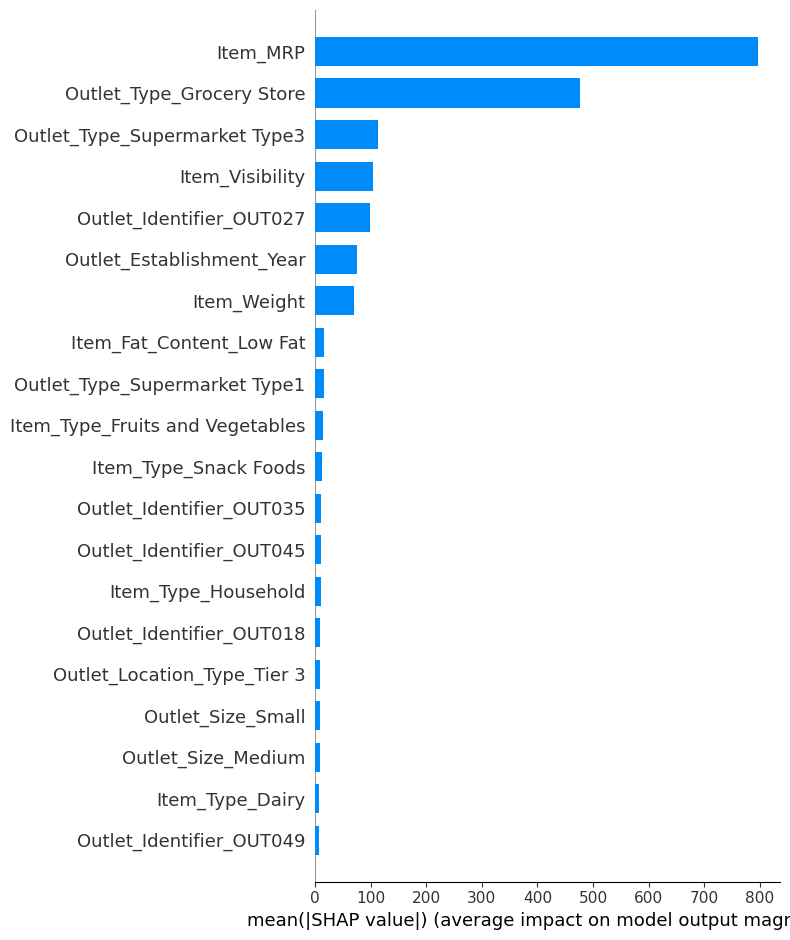

In [13]:
figbar = shap.summary_plot(shap_values,X_shap, plot_type='bar')

![RF](RF.png)

Comparing the most important features according to SHAP vs. our original feature importances:
- The top 2 MRP and Grocery Store are the same.
- However Type 3 Supermarket, Outlet OUT027, and Item Visibility, appear to be the next 3 important features according to SHAP.
- While Item Visibility, Item Weight, and Type 3 Supermarket, are the next in our original.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


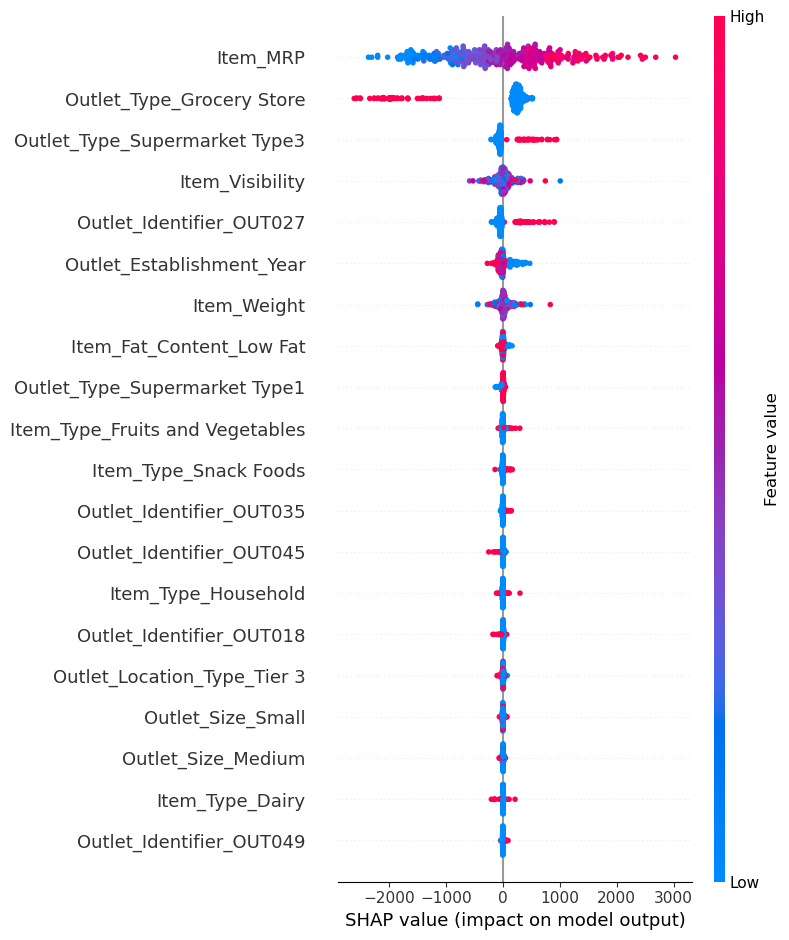

In [14]:
figdot = shap.summary_plot(shap_values,X_shap)

MRP had the largest effect on the model's predictions.

- Because red values are on the right (positive), we can see that the larger the MRP, the more likely the model would predict higher sales.
- We can see that having a higher MRP pushed the model's prediction heavily towards higher sales.

Grocery Stores had the second largest effect on the model's predictions.

- The red values are on the far left (negative) while the blue dots are on the center right, so that if food items were from grocery stores, then the model is much LESS likely to predict higher sales.

Type 3 Supermarket had the third largest effect on the model's predictions.

- The more products were from a type 3 supermarket, the more likely the model would predict higher sales.
- Notice that the blue dots are only slightly to the left of the 0-line, indicating that the model is only slightly less likely to predict lower sales from Type 3 supermarkets.

In [15]:
# create an images folder for storing exported images
# os.makedirs("images/", exist_ok=True)

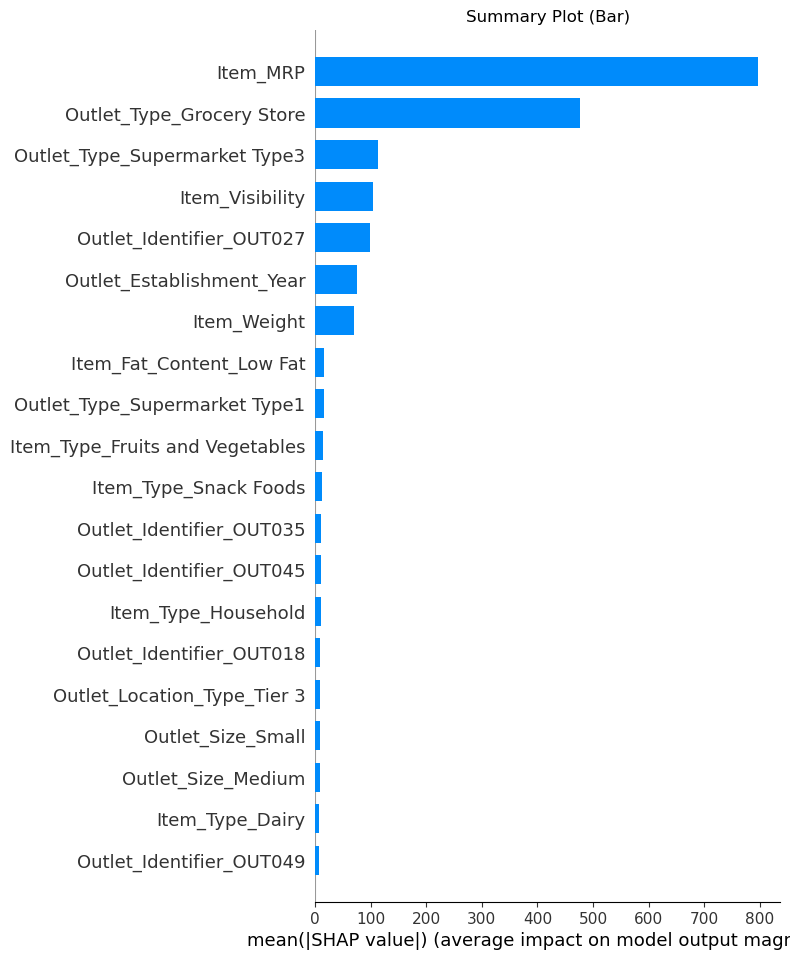

In [16]:
# Save summary barplot
figbar, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, plot_type='bar', show=False)
ax.set_title('Summary Plot (Bar)');
# figbar.savefig('images/summary_plot_bar.png')

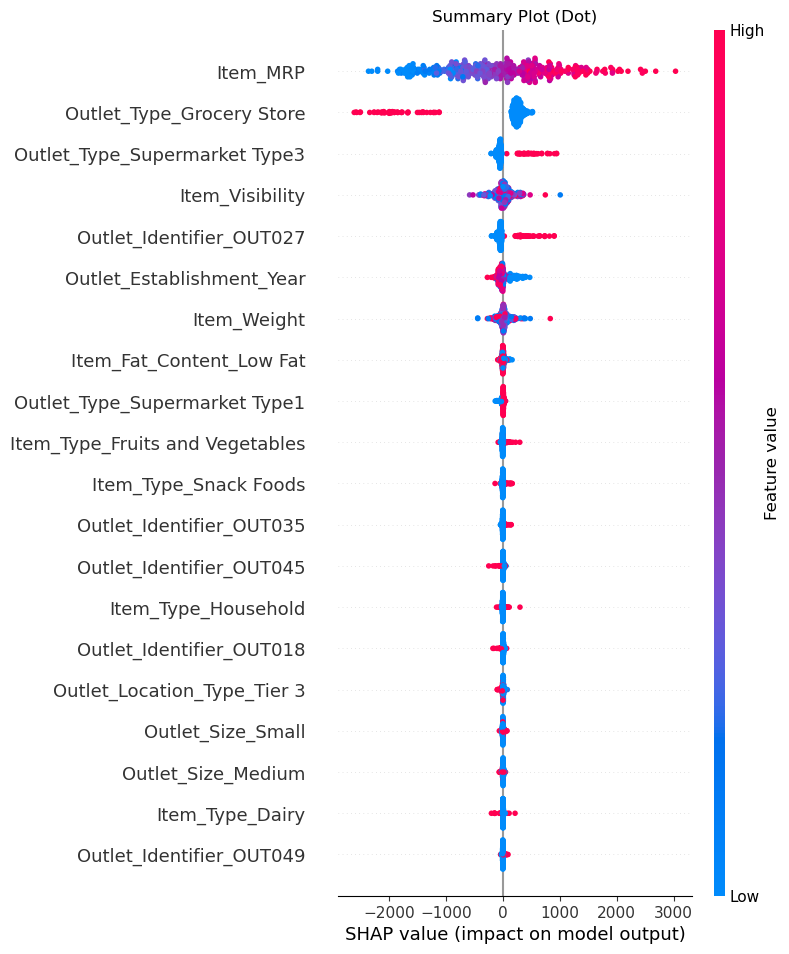

In [17]:
# Save summary shap plot
figdot, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, show=False)
ax.set_title('Summary Plot (Dot)');
# figdot.savefig('images/summary_plot_dot.png')

# Food Sales Predictions: Local Explanations
- Friday March 31st 2023

We filter our top features based on the insights above:

<AxesSubplot: xlabel='Item_MRP', ylabel='Count'>

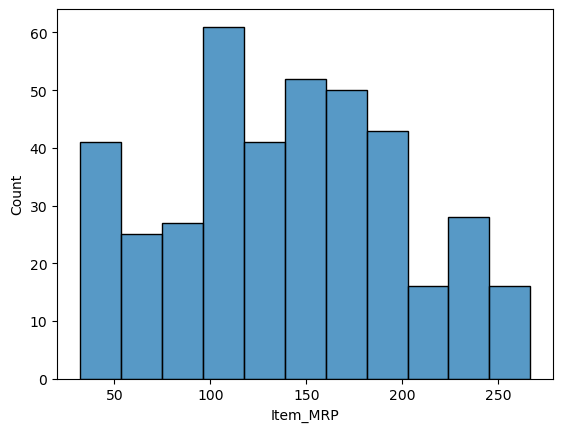

In [18]:
sns.histplot(X_shap['Item_MRP'])

In [19]:
filt_mrptop = X_shap['Item_MRP'] > 250
filt_mrptop.value_counts()

False    388
True      12
Name: Item_MRP, dtype: int64

In [20]:
filt_mrpbot = X_shap['Item_MRP'] < 50
filt_mrpbot.value_counts()

False    361
True      39
Name: Item_MRP, dtype: int64

<AxesSubplot: xlabel='Outlet_Type_Grocery Store', ylabel='Count'>

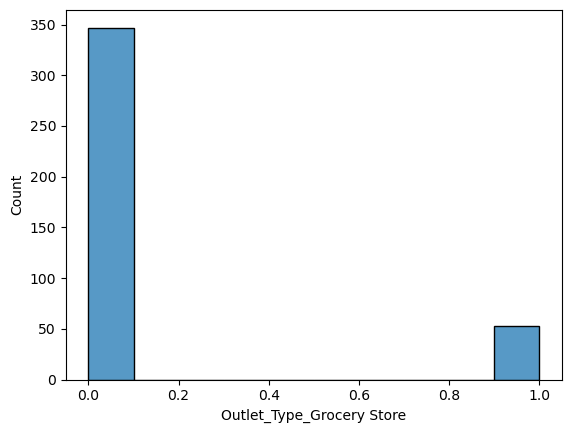

In [21]:
sns.histplot(X_shap['Outlet_Type_Grocery Store'])

In [22]:
filt_groc = X_shap['Outlet_Type_Grocery Store'] > 0.5
filt_groc.value_counts()

False    347
True      53
Name: Outlet_Type_Grocery Store, dtype: int64

<AxesSubplot: xlabel='Item_Visibility', ylabel='Count'>

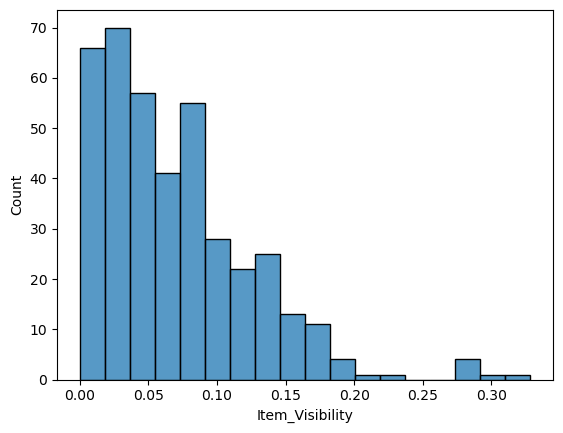

In [23]:
sns.histplot(X_shap['Item_Visibility'])

In [24]:
filt_vis = X_shap['Item_Visibility'] > 0.25
filt_vis.value_counts()

False    394
True       6
Name: Item_Visibility, dtype: int64

<AxesSubplot: xlabel='Outlet_Type_Supermarket Type3', ylabel='Count'>

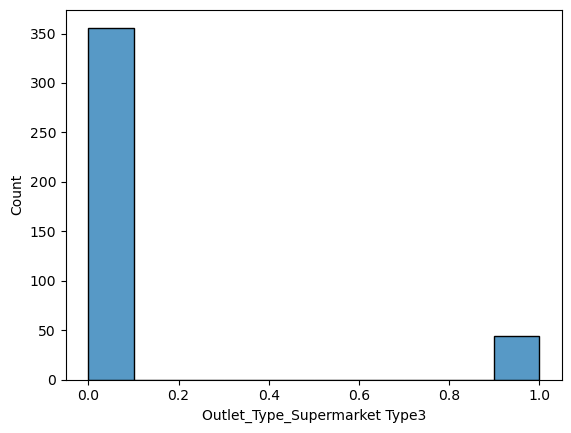

In [25]:
sns.histplot(X_shap['Outlet_Type_Supermarket Type3'])

In [26]:
filt_sup = X_shap['Outlet_Type_Supermarket Type3'] > 0.5
filt_sup.value_counts()

False    356
True      44
Name: Outlet_Type_Supermarket Type3, dtype: int64

In [27]:
X_shap[filt_groc & filt_vis]

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
14         12.65         0.299098  157.8630                     1985.0   
61         12.65         0.328391  146.0418                     1985.0   
162        12.65         0.278974  225.3720                     1985.0   
170        18.60         0.287017   48.8376                     1998.0   
247        12.65         0.277459  156.3946                     1985.0   
385        12.65         0.277459  156.3946                     1985.0   

     Item_Fat_Content_Low Fat  Item_Type_Baking Goods  Item_Type_Breads  \
14                        0.0                     0.0               0.0   
61                        1.0                     0.0               0.0   
162                       1.0                     0.0               0.0   
170                       0.0                     0.0               0.0   
247                       0.0                     0.0               0.0   
385                       0.0                     0.0               0.0   

     Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
14                   0.0               0.0              1.0  ...   
61                   0.0               1.0              0.0  ...   
162                  0.0               0.0              0.0  ...   
170                  0.0               0.0              0.0  ...   
247                  0.0               0.0              0.0  ...   
385                  0.0               0.0              0.0  ...   

     Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  Outlet_Size_MISSING  \
14                        0.0                       0.0                  0.0   
61                        0.0                       0.0                  0.0   
162                       0.0                       0.0                  0.0   
170                       0.0                       0.0                  1.0   
247                       0.0                       0.0                  0.0   
385                       0.0                       0.0                  0.0   

     Outlet_Size_Medium  Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
14                  0.0                1.0                          0.0   
61                  0.0                1.0                          0.0   
162                 0.0                1.0                          0.0   
170                 0.0                0.0                          0.0   
247                 0.0                1.0                          0.0   
385                 0.0                1.0                          0.0   

     Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
14                           0.0                        1.0   
61                           0.0                        1.0   
162                          0.0                        1.0   
170                          1.0                        1.0   
247                          0.0                        1.0   
385                          0.0                        1.0   

     Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type3  
14                             0.0                            0.0  
61                             0.0                            0.0  
162                            0.0                            0.0  
170                            0.0                            0.0  
247                            0.0                            0.0  
385                            0.0                            0.0  

[6 rows x 37 columns]

In [28]:
X_shap[filt_mrptop & filt_groc]

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
81         12.65         0.153457  264.0910                     1985.0   
194        19.85         0.008763  266.6884                     1998.0   

     Item_Fat_Content_Low Fat  Item_Type_Baking Goods  Item_Type_Breads  \
81                        0.0                     0.0               0.0   
194                       1.0                     0.0               0.0   

     Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
81                   0.0               0.0              1.0  ...   
194                  0.0               0.0              1.0  ...   

     Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  Outlet_Size_MISSING  \
81                        0.0                       0.0                  0.0   
194                       0.0                       0.0                  1.0   

     Outlet_Size_Medium  Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
81                  0.0                1.0                          0.0   
194                 0.0                0.0                          0.0   

     Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
81                           0.0                        1.0   
194                          1.0                        1.0   

     Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type3  
81                             0.0                            0.0  
194                            0.0                            0.0  

[2 rows x 37 columns]

In [29]:
X_shap[filt_mrpbot & filt_groc]

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
2          17.25         0.000000   37.5822                     1998.0   
30         12.65         0.106971   44.7744                     1985.0   
170        18.60         0.287017   48.8376                     1998.0   
179        12.65         0.017296   47.1034                     1985.0   
290         7.63         0.225477   45.1402                     1998.0   

     Item_Fat_Content_Low Fat  Item_Type_Baking Goods  Item_Type_Breads  \
2                         1.0                     0.0               0.0   
30                        0.0                     0.0               0.0   
170                       0.0                     0.0               0.0   
179                       1.0                     0.0               0.0   
290                       0.0                     0.0               0.0   

     Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
2                    0.0               0.0              0.0  ...   
30                   0.0               0.0              0.0  ...   
170                  0.0               0.0              0.0  ...   
179                  0.0               0.0              0.0  ...   
290                  0.0               0.0              0.0  ...   

     Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  Outlet_Size_MISSING  \
2                         0.0                       0.0                  1.0   
30                        0.0                       0.0                  0.0   
170                       0.0                       0.0                  1.0   
179                       0.0                       0.0                  0.0   
290                       0.0                       0.0                  1.0   

     Outlet_Size_Medium  Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
2                   0.0                0.0                          0.0   
30                  0.0                1.0                          0.0   
170                 0.0                0.0                          0.0   
179                 0.0                1.0                          0.0   
290                 0.0                0.0                          0.0   

     Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
2                            1.0                        1.0   
30                           0.0                        1.0   
170                          1.0                        1.0   
179                          0.0                        1.0   
290                          1.0                        1.0   

     Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type3  
2                              0.0                            0.0  
30                             0.0                            0.0  
170                            0.0                            0.0  
179                            0.0                            0.0  
290                            0.0                            0.0  

[5 rows x 37 columns]

### We first select the food item has a high MRP (specifically 266.69) and is sold in a grocery store. Our choice is based on the fact that MRP and grocery store outlets are clearly the top 2 most important features.

In [30]:
# Selecting a row
row = 194
print(f"- Row #: {row}")
print(f"- Target: {y_shap.iloc[row]}")
X_shap.iloc[row].round(2)

- Row #: 194
- Target: 264.9884


Item_Weight                          19.85
Item_Visibility                       0.01
Item_MRP                            266.69
Outlet_Establishment_Year          1998.00
Item_Fat_Content_Low Fat              1.00
Item_Type_Baking Goods                0.00
Item_Type_Breads                      0.00
Item_Type_Breakfast                   0.00
Item_Type_Canned                      0.00
Item_Type_Dairy                       1.00
Item_Type_Frozen Foods                0.00
Item_Type_Fruits and Vegetables       0.00
Item_Type_Hard Drinks                 0.00
Item_Type_Health and Hygiene          0.00
Item_Type_Household                   0.00
Item_Type_Meat                        0.00
Item_Type_Seafood                     0.00
Item_Type_Snack Foods                 0.00
Item_Type_Soft Drinks                 0.00
Item_Type_Starchy Foods               0.00
Outlet_Identifier_OUT010              1.00
Outlet_Identifier_OUT013              0.00
Outlet_Identifier_OUT017              0.00
Outlet_Iden

In [31]:
# Instantiate LIME
lime_explainer =LimeTabularExplainer(training_data=X_shap.values, feature_names=X_shap.columns, mode='regression')
lime_explainer

In [32]:
exp = lime_explainer.explain_instance(X_shap.iloc[row],
                               rf_model.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Two features positively influenced the target sale value:
- High Item_MRP	266.69
- Low Item_Visibility 0.01

Three of the most impactful features that negatively influences the target value:
- It is sold in a grocery store
- It is not sold in a Type 3 supermarket
- It is not sold in Outlet 27

In [33]:
y_shap.iloc[row]

264.9884

In [34]:
## Individual forceplot
shap.force_plot(explainer.expected_value,
                shap_values= shap_values[row].values,
               features=X_shap.iloc[row])

### Our second food item has a low MRP (specifically 48.84), is sold in a grocery store, but has relatively high visibility. Our choice is based on the fact that along with MRP and grocery store outlets,visibility is also a top important features.

In [35]:
# Selecting a row
row = 170
print(f"- Row #: {row}")
print(f"- Target: {y_shap.iloc[row]}")
X_shap.iloc[row].round(2)

- Row #: 170
- Target: 47.9376


Item_Weight                          18.60
Item_Visibility                       0.29
Item_MRP                             48.84
Outlet_Establishment_Year          1998.00
Item_Fat_Content_Low Fat              0.00
Item_Type_Baking Goods                0.00
Item_Type_Breads                      0.00
Item_Type_Breakfast                   0.00
Item_Type_Canned                      0.00
Item_Type_Dairy                       0.00
Item_Type_Frozen Foods                0.00
Item_Type_Fruits and Vegetables       0.00
Item_Type_Hard Drinks                 0.00
Item_Type_Health and Hygiene          0.00
Item_Type_Household                   0.00
Item_Type_Meat                        1.00
Item_Type_Seafood                     0.00
Item_Type_Snack Foods                 0.00
Item_Type_Soft Drinks                 0.00
Item_Type_Starchy Foods               0.00
Outlet_Identifier_OUT010              1.00
Outlet_Identifier_OUT013              0.00
Outlet_Identifier_OUT017              0.00
Outlet_Iden

In [36]:
exp = lime_explainer.explain_instance(X_shap.iloc[row],
                               rf_model.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


The only feature that positively influenced the target sale value:
- It is not a starchy food

Three of the most impactful features that negatively influences the target value:
- It is sold in a grocery store
- It has a relatively low MRP
- It is not sold in a Type 3 Supermarket

In [37]:
y_shap.iloc[row]

47.9376

In [38]:
## Individual forceplot
shap.force_plot(explainer.expected_value,
                shap_values= shap_values[row].values,
               features=X_shap.iloc[row])